In [6]:
from rtlsdr import RtlSdr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import csv
import time
import math

In [7]:
sdr = RtlSdr()
sdr.sample_rate = 2.4e6 # Hz
sdr.center_freq = 92.7e6   # Hz
sdr.freq_correction = 60  # PPM
sdr.gain = 'auto'

print(len(sdr.read_samples(1024)))
sdr.close()

1024


[-9.9, -4.0, 7.1, 17.9, 19.2]
0.0


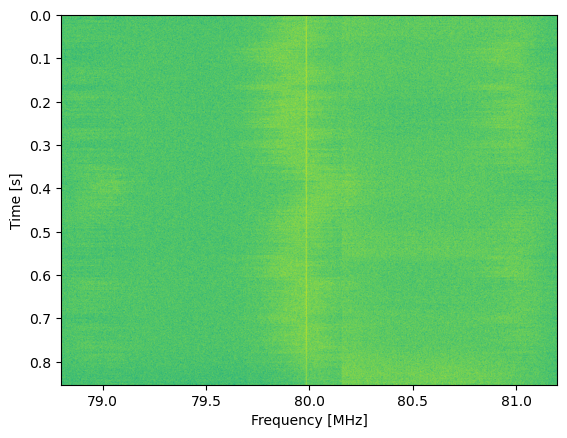

In [8]:

sdr = RtlSdr()
sdr.sample_rate = 2.4e6 # Hz
sdr.center_freq = 80.0e6   # Hz
sdr.freq_correction = 60  # PPM
print(sdr.valid_gains_db)
sdr.gain = 49.6
print(sdr.gain)
fft_size = 1024
num_rows = 2000
#x = sdr.read_samples(2048*2400) # set how mnay samples to listen to
x = sdr.read_samples(fft_size*num_rows) # get all the samples we need for the spectrogram
spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x[i*fft_size:(i+1)*fft_size])))**2)
extent = [(sdr.center_freq + sdr.sample_rate/-2)/1e6,
            (sdr.center_freq + sdr.sample_rate/2)/1e6,
            len(x)/sdr.sample_rate, 0]
plt.imshow(spectrogram, aspect='auto', extent=extent)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()
sdr.close()


In [9]:
spect_df = pd.DataFrame(spectrogram)
spect_df.to_csv("spectrogram.csv")

In [21]:
spect_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,20.823035,12.697901,15.322600,16.022518,17.545851,17.692029,15.191904,11.527938,20.041168,19.716693,...,14.163631,12.797923,17.224280,16.536306,19.701350,21.359600,16.484673,17.845234,6.642654,13.791696
1,12.694824,10.493553,18.085250,0.474505,15.900196,11.112356,18.971037,13.346285,11.456846,23.938782,...,24.737056,20.840277,7.452296,0.129387,20.305112,15.179818,24.688064,16.882872,16.677093,19.585970
2,28.132039,29.259015,22.505333,26.389469,28.899597,27.236507,26.606311,26.553891,23.889522,29.679204,...,23.429752,26.988805,29.859824,29.220093,22.863707,28.104561,25.247554,26.537966,21.998452,9.496779
3,23.597318,15.229681,19.891275,23.755097,31.990064,24.246704,28.115348,31.251576,20.261783,25.493034,...,27.544994,26.739505,26.653093,29.821296,16.476149,23.496846,29.673576,25.856646,28.417354,28.196260
4,24.468956,17.150596,24.412039,19.840591,21.396827,26.898384,27.167080,17.061226,28.344257,24.718533,...,30.459860,20.849832,18.498578,27.068069,27.534995,30.664275,30.170450,26.381694,27.870440,30.195018


In [10]:
interval_width = 5
num_intervals = int(num_rows/interval_width)
mean_vals = np.zeros((num_intervals, 1))

for i in range(0,num_rows,interval_width):
    mean_vals[int(i/interval_width)] = spect_df.iloc[i:i+interval_width].values.mean()


Text(0, 0.5, 'energy (in dB)')

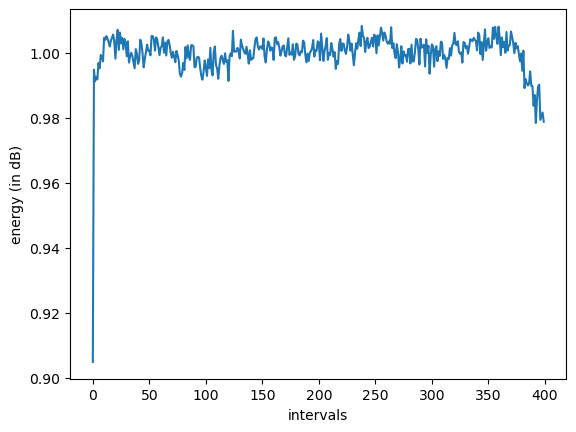

In [11]:
noise_floor = np.sqrt(np.mean(mean_vals**2))
normalized_mean_vals = mean_vals/noise_floor
plt.plot(range(0,num_intervals),normalized_mean_vals)
normalized_mean_vals.max() - normalized_mean_vals.min()
plt.xlabel("intervals")
plt.ylabel("energy (in dB)")

In [12]:
d_mean_vals = np.zeros((num_intervals,1))
for i in range(0,num_intervals-1):
    d_mean_vals[i] = (normalized_mean_vals[i+1] - normalized_mean_vals[i])/interval_width

3.696257438934007e-05

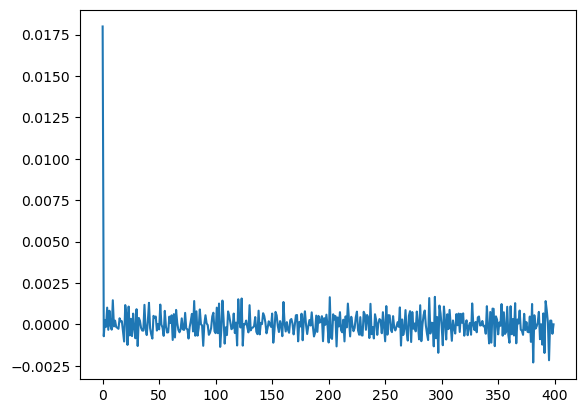

In [13]:
plt.plot(range(0,num_intervals),d_mean_vals)
mean_change = d_mean_vals.mean()
mean_change

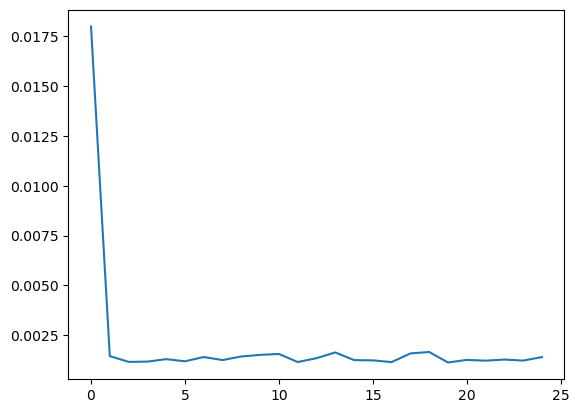

In [20]:
above_threshold = d_mean_vals[d_mean_vals > mean_change*30]

plt.plot(range(0,len(above_threshold)),above_threshold)